# SDF

In [41]:
from collections import OrderedDict

#import jinja2
import matplotlib.pyplot as plt
#import os
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm

%matplotlib inline

In [48]:
plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
factors = pd.read_csv("C:/Data/Thesis/_Factors.csv")

myfactors = pd.read_csv("C:/Data/Thesis/_MyFactors.csv")
myfactors.iloc[:,1:] = myfactors.iloc[:,1:]*100

f = pd.concat([factors, myfactors[["HML", "HMLm", "PMU06", "PMU16", "PMU", "CMA", "WML"]]], axis=1)
f.date = pd.to_datetime(f.date.astype("str"), format="%Y%m")
f = f.set_index("date")

f.head()

,rf,rm,smb,hml,rmw,cma,wml,str,hmlm,bab,qmj,HML,HMLm,PMU06,PMU16,PMU,CMA,WML
date,,,,,,,,,,,,,,,,,,
1963-07-01,0.27,-0.39,-0.46,-0.81,0.72,-1.16,0.99,-0.04,-0.59,0.81,0.47,-0.721155,-0.864465,0.888426,0.739828,0.355650,-1.132040,0.550726
1963-08-01,0.25,5.07,-0.81,1.65,0.42,-0.40,1.08,1.36,0.28,-1.22,-0.63,1.000628,-0.060107,0.212301,0.470122,0.456718,-0.070141,1.443902
1963-09-01,0.27,-1.57,-0.48,0.19,-0.80,0.23,0.13,1.20,0.27,1.07,0.61,1.045719,1.463823,-1.169019,-1.130309,-0.665664,-0.361107,0.267052
1963-10-01,0.29,2.53,-1.29,-0.09,2.75,-2.26,3.14,-0.66,-2.11,-1.88,2.08,-0.549914,-1.635921,2.612164,3.006009,3.007174,-1.886318,3.648531
1963-11-01,0.27,-0.85,-0.85,1.71,-0.34,2.22,-0.75,1.15,0.91,-0.52,-0.88,1.288533,1.400487,-0.099125,-0.481188,-0.625498,0.314912,-1.489579


Factor weights in max Sh2 portfolio

$$E(R_p) = w'\bar{R}$$
$$Var(R_p) = w'V_Rw$$
$$Sh^2(f) = \bar{f}'V_f^{-1}\bar{f}$$

In [3]:
def E(w, R):
    """Expected return on portfolio given vector of weights `w` and matrix of returns `R`
    
    Returns scalar"""

    return w.transpose() @ pd.np.mean(R, axis=0)

def V(w, R):
    """Variance of portfolio given vector of weights `w` and matrix of returns `R`

    Returns scalar"""

    return w.transpose() @ pd.np.cov(R, rowvar=False) @ w

def SR(w, R):
    """Sharpe ratio of portfolio given weights `w` and matrix of returns `R`

    Returns scalar"""

    return (E(w, R) / pd.np.sqrt(V(w, R)))

def obj_SR(*args, **kwargs):
    """Objective function to minimize negative Sharpe ratio.

    Wrapped function expects vector of weights `w` and matrix of returns `R`

    Returns optimization results object"""

    return -SR(*args, **kwargs)

# equality constraint functions are set to 0
cons = ({"type": "eq", "fun": lambda w: pd.np.sum(w) - 1},)

In [4]:
ValMom = f["1963-07":"2017-12"][["hmlm", "wml"]].as_matrix()
ValMom_res = minimize(obj_SR, [.5,.5], args=(ValMom,), constraints=cons)
ValMom_res["x"].round(2), SR(ValMom_res["x"], ValMom)

(array([0.52, 0.48]), 0.29413184785396596)

In [5]:
SDF = f["1963-07":"2017-12"][["rm", "smb", "hmlm", "wml", "PMU"]].as_matrix()
SDF_res = minimize(obj_SR, [.2,.2,.2,.2,.2], args=(SDF,), constraints=cons)
SDF_res["x"].round(2), SR(SDF_res["x"], SDF)

(array([0.1 , 0.07, 0.23, 0.14, 0.46]), 0.5624495392772361)

In [6]:
SDF2 = f["1963-07":"2017-12"][["rm", "smb", "hml", "PMU", "cma"]].as_matrix()
SDF2_res = minimize(obj_SR, [.2,.2,.2,.2,.2], args=(SDF2,), constraints=cons)
SDF2_res["x"].round(2), SR(SDF2_res["x"], SDF2)

(array([0.12, 0.1 , 0.13, 0.54, 0.12]), 0.47416457882441704)

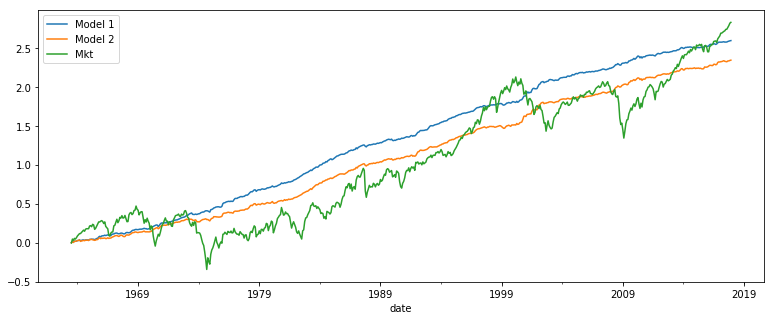

In [45]:
df = pd.DataFrame(OrderedDict([
    ("Model 1", SDF.dot(SDF_res["x"])),
    ("Model 2", SDF2.dot(SDF2_res["x"])),
    ("Mkt", f["1963-07":"2017-12"]["rm"]),
    #("Mom", f["1963-07":"2017-12"]["wml"]),
    #("Val", f["1963-07":"2017-12"]["hmlm"]),
    #("ValMom", ValMom.dot(ValMom_res["x"])),
]))/100

# (df + 1).cumprod().plot()
pd.np.log(df + 1).cumsum().plot()

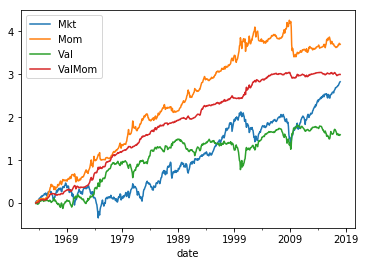

In [8]:
df = pd.DataFrame(OrderedDict([
    #("Model 1", SDF.dot(SDF_res["x"])),
    #("Model 2", SDF2.dot(SDF2_res["x"])),
    ("Mkt", f["1963-07":"2017-12"]["rm"]),
    ("Mom", f["1963-07":"2017-12"]["wml"]),
    ("Val", f["1963-07":"2017-12"]["hmlm"]),
    ("ValMom", ValMom.dot(ValMom_res["x"])),
]))/100

# (df + 1).cumprod().plot()
pd.np.log(df + 1).cumsum().plot()

In [9]:
a = pd.read_csv("C:/Data/FrenchDartmouth/25_Portfolios_ME_VAR_5x5.csv")
a.index = f.index

In [61]:
a.columns

Index(['date', 'SMALL LoVAR', 'ME1 VAR2', 'ME1 VAR3', 'ME1 VAR4',
       'SMALL HiVAR', 'ME2 VAR1', 'ME2 VAR2', 'ME2 VAR3', 'ME2 VAR4',
       'ME2 VAR5', 'ME3 VAR1', 'ME3 VAR2', 'ME3 VAR3', 'ME3 VAR4', 'ME3 VAR5',
       'ME4 VAR1', 'ME4 VAR2', 'ME4 VAR3', 'ME4 VAR4', 'ME4 VAR5', 'BIG LoVAR',
       'ME5 VAR2', 'ME5 VAR3', 'ME5 VAR4', 'BIG HiVAR'],
      dtype='object')

In [25]:
sdf = pd.Series(SDF.dot(SDF_res["x"]), index=f.index)

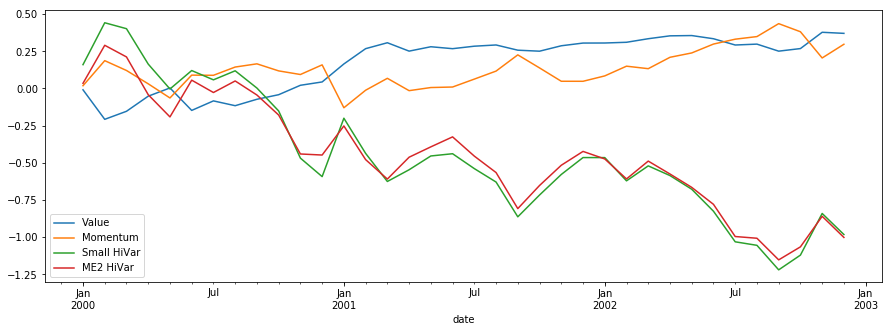

In [65]:
start, end = "2000", "2002"

df = pd.DataFrame(OrderedDict([
    #("Mkt", f["1963-07":"2017-12"]["rm"]),
    #("SDF", sdf[start:end]),
    #("Size", f[start:end]["smb"]),
    ("Value", f[start:end]["hmlm"]),
    ("Momentum", f[start:end]["wml"]),
    #("Prof", f[start:end]["PMU"]),
    ("Small HiVar", a[start:end]["SMALL HiVAR"]),
    ("ME2 HiVar", a[start:end]["ME2 VAR5"]),
    #("BL", a[start:end]["BIG LoVAR"]),
]))/100

# (df + 1).cumprod().plot()
pd.np.log(df + 1).cumsum().plot()

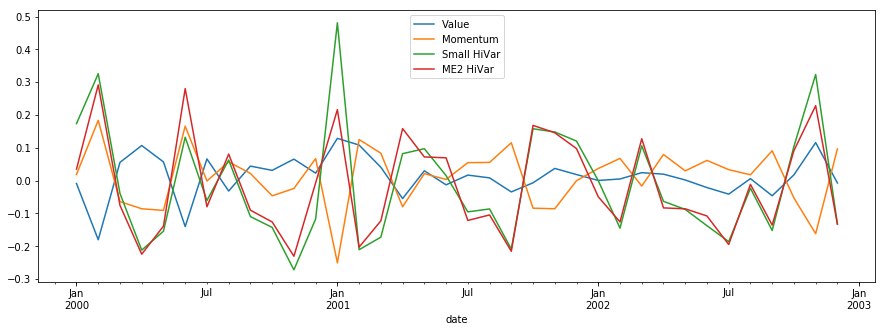

In [66]:
df.plot()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     283.3
Date:                Tue, 01 May 2018   Prob (F-statistic):          9.12e-141
Time:                        11:03:09   Log-Likelihood:                -2046.3
No. Observations:                 654   AIC:                             4103.
Df Residuals:                     649   BIC:                             4125.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0837      0.247     -0.339      0.7

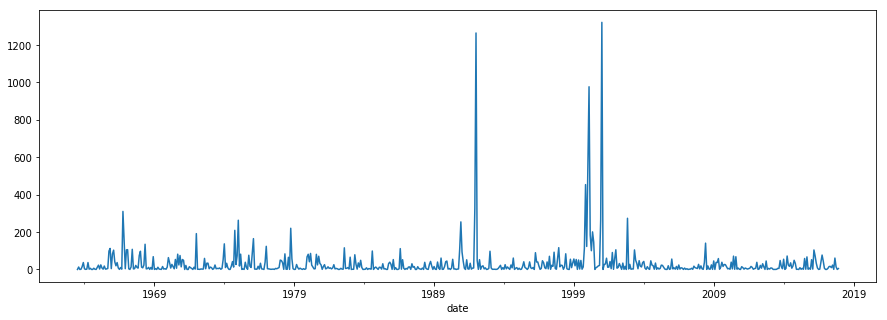

In [67]:
rhs = sm.add_constant(f[["rm", "hmlm", "wml", "PMU"]])
lhs = a["SMALL HiVAR"] - f["rf"]

model = sm.OLS(lhs, rhs)
fit = model.fit()
print(fit.summary())
(fit.resid**2).plot()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     707.4
Date:                Tue, 01 May 2018   Prob (F-statistic):          1.16e-259
Time:                        11:03:18   Log-Likelihood:                -1766.7
No. Observations:                 654   AIC:                             3545.
Df Residuals:                     648   BIC:                             3572.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7531      0.163     -4.634      0.0

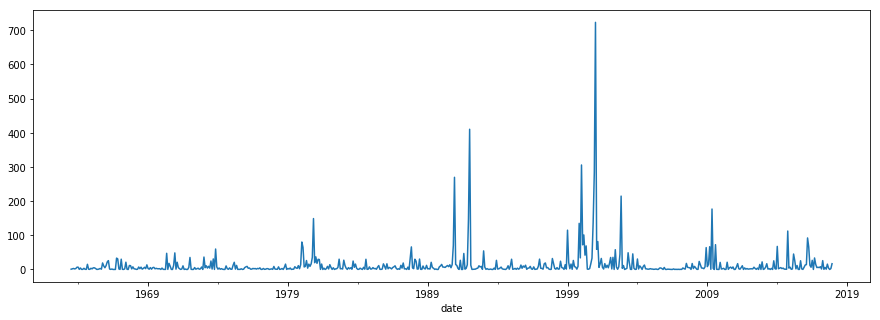

In [68]:
rhs = sm.add_constant(f[["rm", "smb", "hmlm", "wml", "PMU"]])
lhs = a["SMALL HiVAR"] - f["rf"]

model = sm.OLS(lhs, rhs)
fit = model.fit()

print(fit.summary())
(fit.resid**2).plot()

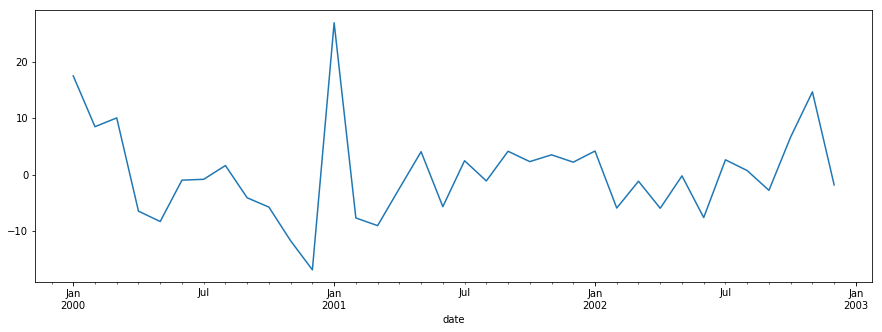

In [69]:
fit.resid["2000":"2002"].plot()

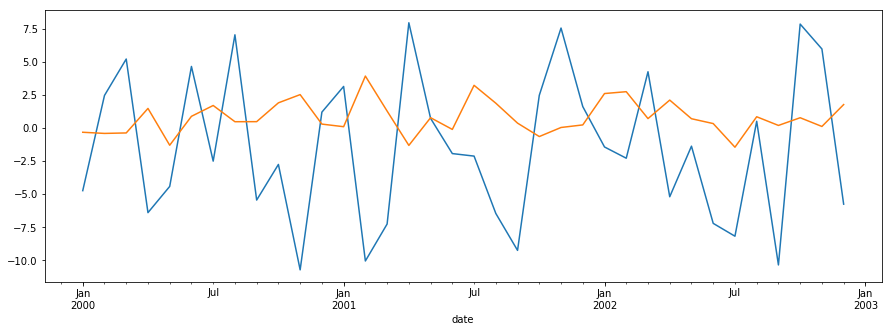

In [70]:
f["rm"]["2000":"2002"].plot()
pd.Series(SDF.dot(SDF_res["x"]), index=f.index)["2000":"2002"].plot()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     270.6
Date:                Fri, 27 Apr 2018   Prob (F-statistic):          1.06e-136
Time:                        15:36:40   Log-Likelihood:                -2055.8
No. Observations:                 654   AIC:                             4122.
Df Residuals:                     649   BIC:                             4144.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1307      0.241     -0.542      0.5

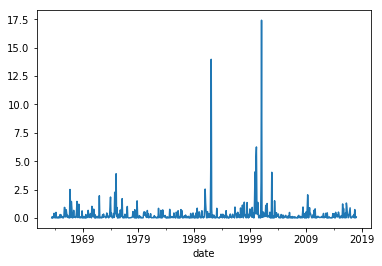

In [72]:
rhs = sm.add_constant(f[["rm", "hml", "PMU", "cma"]])
lhs = a["SMALL HiVAR"] - f["rf"]

model = sm.OLS(lhs, rhs)
fit = model.fit()

print(fit.summary())
(fit.resid**2/100).plot()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     596.9
Date:                Fri, 27 Apr 2018   Prob (F-statistic):          9.04e-240
Time:                        15:36:56   Log-Likelihood:                -1812.9
No. Observations:                 654   AIC:                             3638.
Df Residuals:                     648   BIC:                             3665.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8015      0.168     -4.763      0.0

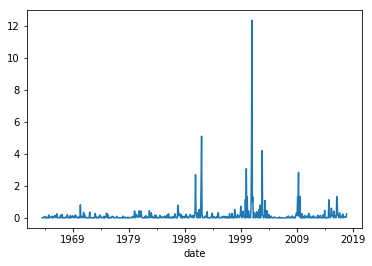

In [73]:
rhs = sm.add_constant(f[["rm", "smb", "hml", "PMU", "cma"]])
lhs = a["SMALL HiVAR"] - f["rf"]

model = sm.OLS(lhs, rhs)
fit = model.fit()

print(fit.summary())
(fit.resid**2/100).plot()

In [58]:
lhs["2000":"2002"]

date
2000-01-01    16.9506
2000-02-01    32.1340
2000-03-01    -4.3854
2000-04-01   -21.6486
2000-05-01   -15.9236
2000-06-01    12.8160
2000-07-01    -6.5422
2000-08-01     5.7698
2000-09-01   -11.4733
2000-10-01   -14.8274
2000-11-01   -27.7034
2000-12-01   -12.1923
2001-01-01    47.5583
2001-02-01   -21.4342
2001-03-01   -17.6499
2001-04-01     7.8202
2001-05-01     9.3982
2001-06-01     1.2379
2001-07-01    -9.8256
2001-08-01    -8.9470
2001-09-01   -21.1385
2001-10-01    15.5726
2001-11-01    14.6513
2001-12-01    11.8897
2002-01-01    -0.1537
2002-02-01   -14.6099
2002-03-01    10.4586
2002-04-01    -6.4629
2002-05-01    -8.9196
2002-06-01   -13.8705
2002-07-01   -18.7529
2002-08-01    -2.4791
2002-09-01   -15.3445
2002-10-01    10.2776
2002-11-01    32.2163
2002-12-01   -13.3286
dtype: float64